In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import scipy
import torch.nn as nn
from torchdiffeq import odeint
from odes.neural_ODE import *

In [2]:
i = 7

file_path = "data/patient_"+str(i)+".csv"
data = pd.read_csv(file_path, header=None)

data_time = np.array(data[0])
data_v_load = np.array(data[1])

interp_fn = scipy.interpolate.interp1d(data_time, data_v_load)

In [3]:
dt = 0.05
sim_time = 13

num_steps = int(sim_time/dt)
time = torch.tensor(np.linspace(0, sim_time, num_steps+1))

start = 50
stop = -30
step = 10

train_times = time[start:stop:step]

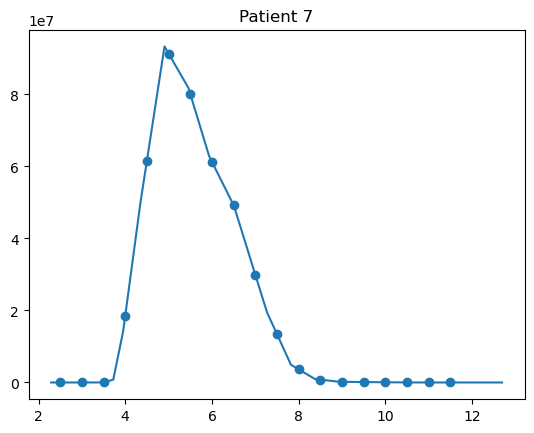

In [4]:
plt.plot(data_time, data_v_load)
plt.scatter(train_times, interp_fn(train_times))
# plt.yscale('log')
plt.title("Patient "+str(i))
plt.show()

In [5]:
class Pair_NODE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.num_hosts = 2
        self.nUIV_x0_0 = nn.Parameter(torch.rand(4))
        self.nUIV_x0 = torch.cat((self.nUIV_x0_0, torch.tensor([0, 0], dtype=torch.float32)))
        self.nUIV_dynamics = nUIV_rhs(self.num_hosts)  # initialize a random nUIV

        self.parametrization = squared_parametrization()
        P.register_parametrization(self, 'nUIV_x0_0', self.parametrization)

        self.method = kwargs.pop('method', 'rk4')
        self.step_size = kwargs.pop('step_size', None)

    def simulate(self, times):
        solution = odeint(self.nUIV_dynamics, self.nUIV_x0,
                          times, method=self.method, options=dict(step_size=self.step_size)).to(times.device)
        if torch.isnan(solution).any():
            print("Cannot solve the ODEs!")
            print(solution)
        # return torch.reshape(solution, (len(times), self.num_hosts, 3))
        return solution

In [6]:
num_epochs = 400

step_size = dt
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Pair_NODE(step_size=step_size, method="euler").to(device)

loss_function = lambda y, yhat: torch.norm(y-yhat, p=2)  # nn.L1Loss()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

scale_factor = 1e7
train_v_loads = torch.tensor(interp_fn(train_times)).to(device)/scale_factor

In [8]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    sol = model.simulate(time.to(device)).to(device)
    est_v_loads = sol[start:stop:step, 5]

    loss = loss_function(est_v_loads, train_v_loads)
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 15.939533521423519.
Epoch 1, loss value: 15.645929098110958.
Epoch 2, loss value: 15.089607345701255.
Epoch 3, loss value: 14.332431714616497.
Epoch 4, loss value: 16.14813420954718.
Epoch 5, loss value: 13.849190671780928.
Epoch 6, loss value: 13.76335740553072.
Epoch 7, loss value: 13.763880612904625.
Epoch 8, loss value: 13.721234915580421.
Epoch 9, loss value: 13.611267149237204.
Epoch 10, loss value: 13.442515473086763.
Epoch 11, loss value: 13.222372847009643.
Epoch 12, loss value: 12.983386819726295.
Epoch 13, loss value: 12.798226972991667.
Epoch 14, loss value: 12.724352876990134.
Epoch 15, loss value: 12.690070166609688.
Epoch 16, loss value: 12.5880166629188.
Epoch 17, loss value: 12.382121406521744.
Epoch 18, loss value: 11.968670802214005.
Epoch 19, loss value: 11.866551142150737.
Epoch 20, loss value: 11.913957728638707.
Epoch 21, loss value: 11.709988098947552.
Epoch 22, loss value: 11.374900459377933.
Epoch 23, loss value: 11.449543389021585.
Epoch 

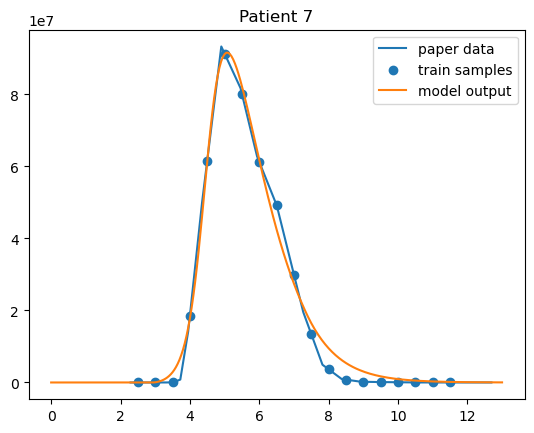

In [9]:
final_sol = sol.detach().numpy()*scale_factor

plt.plot(data_time, data_v_load, label="paper data")
plt.scatter(train_times, interp_fn(train_times), label="train samples")
plt.plot(time, final_sol[:,-1], label="model output")
plt.title("Patient "+str(i))
# plt.yscale('log')
plt.legend()
plt.show()

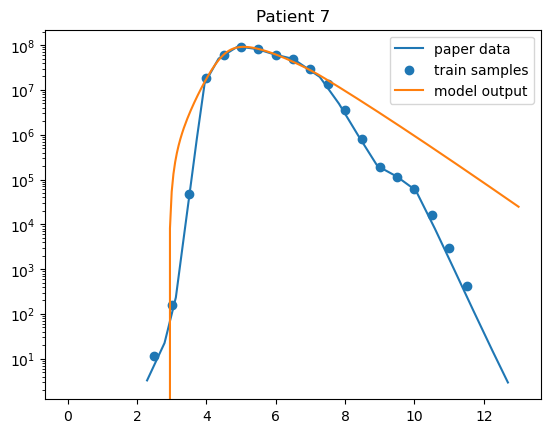

In [10]:
plt.plot(data_time, data_v_load, label="paper data")
plt.scatter(train_times, interp_fn(train_times), label="train samples")
plt.plot(time, final_sol[:,-1], label="model output")
plt.yscale('log')
plt.title("Patient "+str(i))
plt.legend()
plt.show()